# Test Twe for the Classical SRNN

This is a notebook for testing the classical SRNN.

## Import everything

Modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
currentPath=os.getcwd()

Import matplotlib and others

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

Import the classical SRNN and others

In [3]:
#Modify path for the notebooks
currentPath=os.path.join(currentPath,'..')
currentPath=os.path.join(currentPath,'src')
os.chdir(currentPath)

In [4]:
from DataGenerator.HenonMapDataGen import HenonMapDataGen
from ClassicalModels.ClassicalSRNNs import ClassicalSRNN
from ClassicalModels.ClassicalSRNNs import SuportFunction
from GradientFreeOptimizers.CostFunc import GradFreeMSELoss
import GradientFreeOptimizers.Helpers as hp

## Test Two

### Get the data

#### Set save path

In [5]:
savepath=os.path.join(currentPath,'..\data\HenonMap\Test')
filename='ClassicalSRNNTest2.csv'

In [6]:
'''
hmap=HenonMapDataGen(n=2,heavyMem=False,savepath=savepath)
hmap(10000)
hmap.save_to_CSV(filename)
''';

#### Read the data

In [7]:
hmap=HenonMapDataGen(savepath=savepath)
hmap.read_from_CSV(filename)

In [8]:
print(hmap)

Data Info:
----------------------------------------
Data Size: 10000
Data Interval: 2
Data ParamA: 1.4, Data ParamB: 0.3
Data Bound: -1.2
Data HeavyMem: False
Data Seed:
 [0.08559870591945942, 0.04131970884614906, 0.02159763002604379, 0.011121474606073043]
----------------------------------------


#### Generate the data iter

In [9]:
testSetRatio=0.2
numStep=20
batchSize=4

In [10]:
trainIter,testIter=hmap.get_data_iter(testSetRatio,numStep,batchSize,shuffle=True)

In [11]:
X,Y=next(iter(trainIter))
print('Train Data Size:',len(trainIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Train Data Size: 399
X= tensor([[ 0.8983, -0.3071, -0.2953,  1.1697,  1.1474, -1.0078, -0.9317, -0.0709,
          0.1290,  0.6906,  0.6972,  0.3110,  0.3582,  1.0718,  1.0296, -0.5150,
         -0.3765,  0.9502,  1.1104, -0.4185],
        [ 1.2571,  0.1667, -1.2000,  0.6862, -0.6389,  0.3909,  0.0686,  0.9919,
          0.8018, -0.2603,  0.1206,  1.2027,  1.2202, -1.1033, -1.0481, -0.3434,
         -0.1719,  0.5039,  0.6442,  0.5414],
        [ 0.3192,  0.4718,  1.0692,  0.8847, -0.5047,  0.0457,  0.9641,  1.2625,
         -0.4527, -1.2000,  1.0023, -0.6373, -0.5422,  0.0715,  0.8891,  0.8017,
         -0.2693,  0.1217,  1.1652,  1.2198],
        [-0.3234,  1.0210,  1.1274, -0.3496, -0.8763,  1.1352,  0.2631, -0.9090,
          0.6402,  0.1837,  0.5051,  0.6800,  0.8348,  0.4077,  0.1758,  0.9713,
          1.2072, -0.1986, -0.9874,  1.2362]])
Y= tensor([[ 0.0000,  0.0000,  1.1474, -1.0078, -0.9317, -0.0709,  0.1290,  0.6906,
          0.6972,  0.3110,  0.3582,  1.0718,  1.0296, -0.51

In [12]:
X,Y=next(iter(testIter))
print('Test Data Size:',len(testIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Test Data Size: 99
X= tensor([[ 0.0739,  1.2701,  0.8016, -1.2000,  0.1226, -0.6350,  1.2194,  0.0755,
         -1.0450,  0.8015, -0.1631,  0.1232,  0.6493,  1.2192,  0.3609, -1.0440,
          1.0124, -0.1602, -0.3267,  0.6508],
        [ 0.1186,  0.8608,  1.2209,  0.0972, -1.0512,  1.2450, -0.1807, -1.1409,
          0.6389, -0.4488,  0.3742,  0.3757,  0.9956,  0.6677, -0.2755,  0.4885,
          1.1925,  0.8662, -1.0734,  0.0961],
        [-0.7355,  1.0232,  0.5655, -0.6029,  0.3317,  0.7980,  1.0157, -0.0725,
         -0.3447,  1.2321,  1.1384, -1.1469, -0.9176, -0.4719,  0.1627,  0.3442,
          0.6877,  0.6926,  0.3868,  0.4317],
        [ 0.1234, -0.6370,  1.2191,  0.0720, -1.0438,  0.8017, -0.1595,  0.1219,
          0.6513,  1.2197,  0.3583, -1.0462,  1.0156, -0.1664, -0.3365,  0.6474,
          1.1461,  0.3633, -0.9400,  1.0094]])
Y= tensor([[ 0.0000,  0.0000,  0.1226, -0.6350,  1.2194,  0.0755, -1.0450,  0.8015,
         -0.1631,  0.1232,  0.6493,  1.2192,  0.3609, -1.0440

### Define the SRNN

#### Get neccesary functions

In [13]:
srnnTestSup=SuportFunction()

In [14]:
transform=lambda Xs:[torch.squeeze(x) for x in Xs]

In [15]:
init_rnn_state=srnnTestSup.get_init_state_fun()
get_params=srnnTestSup.get_get_params_fun()
rnn=srnnTestSup.get_forward_fn_fun()
if hmap.heavyMem==False:
    predict_fun=srnnTestSup.get_predict_fun(outputTransoform=transform,interval=hmap.interval)
else:
    predict_fun=srnnTestSup.get_predict_fun(outputTransoform=transform)

#### Create the SRNN

In [16]:
inputSize=outputSize=1
hiddenSize=6

In [17]:
net=ClassicalSRNN(inputSize,hiddenSize,outputSize,get_params,init_rnn_state,rnn)

#### Test prediction

In [18]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0].shape

(torch.Size([80, 1]), 1, torch.Size([4, 6]))

In [19]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[:3],-1),torch.unsqueeze(preY[:10],-1)
print('preX=',preX)
preY=[y for y in torch.cat((preX[:3],preY[2:]),dim=0)]
print('preY=',preY)

preX= tensor([[0.0856],
        [0.0413],
        [0.0216]])
preY= [tensor([0.0856]), tensor([0.0413]), tensor([0.0216]), tensor([1.0250]), tensor([1.0122]), tensor([-0.4645]), tensor([-0.4311]), tensor([1.0055]), tensor([1.0435]), tensor([-0.5547]), tensor([-0.6537])]


In [20]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=7)
print('YHat=',YHat)

YHat= [tensor(0.0856), tensor(0.0413), tensor(0.0216), tensor(-2.7555e-06), tensor(-1.4378e-06), tensor(-1.6225e-08), tensor(1.0670e-10), tensor(2.2428e-11), tensor(2.0445e-13), tensor(-5.9989e-15)]


### Train the network

#### Parameters

In [21]:
num_epochs, lr = 2000, 0.1

#### Loss function

In [22]:
lossFunc=GradFreeMSELoss(net)

#### Trainer

In [23]:
trainer = torch.optim.SGD(net.params, lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(trainer,step_size=250,gamma=0.1)

#### Initial loss

In [24]:
l_epochs=[]
train_l=SuportFunction.evaluate_accuracy(net,trainIter,lossFunc,False)
test_l=SuportFunction.evaluate_accuracy(net,testIter,lossFunc,False)
l_epochs.append([train_l,test_l])
print('Initial Train Loss:',train_l)
print('Initial Test Loss:',test_l)

Initial Train Loss: 0.5195209980010986
Initial Test Loss: 0.5201730847358703


#### Training

TestLoss 0.052213, 14571.777479 point/s
Prediction:
 [tensor(0.0856), tensor(0.0413), tensor(0.0216), tensor(0.8758), tensor(0.9691), tensor(-0.2070), tensor(-0.3657), tensor(1.0198), tensor(0.9533), tensor(-0.5345), tensor(-0.3480), tensor(0.6596)]
Answer:
 [tensor([0.0856]), tensor([0.0413]), tensor([0.0216]), tensor([1.0250]), tensor([1.0122]), tensor([-0.4645]), tensor([-0.4311]), tensor([1.0055]), tensor([1.0435]), tensor([-0.5547]), tensor([-0.6537])]


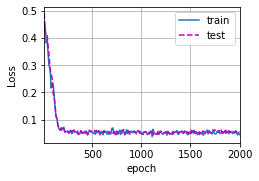

In [25]:
animator = hp.Animator(xlabel='epoch', ylabel='Loss',
                            legend=['train','test'], xlim=[10, num_epochs])
    # prediction
predict = lambda prefix: predict_fun(prefix,net, numPreds=9)
# train and predict
for epoch in range(num_epochs):
    trainLoss, speed = SuportFunction.train_epoch(
        net, trainIter, lossFunc, trainer, True)
    testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, True)
    if (epoch + 1) % 10 == 0:
        print(predict(preX))
        animator.add(epoch + 1, [trainLoss,testLoss])
    l_epochs.append([trainLoss,testLoss])
    scheduler.step()
testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, True)
print(f'TestLoss {testLoss:f}, {speed:f} point/s')
print('Prediction:\n',predict(preX))
print('Answer:\n',preY)

### Visualize the performance

#### One Step Prediction

In [26]:
X,Y=next(iter(testIter))
state=net.begin_state(batchSize)
Y_hat,newState=net(X,state)
print('X=',torch.squeeze(X))
print('Prediction=',torch.squeeze(Y_hat).detach())
Y=Y.transpose(0,1).reshape([-1,Y.shape[-1]])
print('Y=',torch.squeeze(Y))

X= tensor([[-1.0293, -0.3383, -0.1301,  1.1446,  0.6675, -0.9357,  0.3372,  0.1176,
          1.0411,  0.6999, -0.4163,  0.3494,  1.0697,  1.0390, -0.7269, -0.4066,
          0.5812,  1.0803,  0.3090, -0.7558],
        [ 0.3009, -0.1643,  1.1087,  0.6486, -0.6307,  0.3618,  0.7757,  1.0113,
         -0.0317, -0.3233,  1.2313,  1.1571, -1.1321, -0.9714, -0.4249,  0.0261,
          0.4076,  0.7076,  0.6399,  0.3068],
        [-0.5087, -1.2000,  0.9345, -0.6345, -0.3751,  0.0764,  1.0833,  0.8015,
         -0.7556,  0.1236,  0.5257,  1.2191,  0.3864, -1.0435,  0.9487, -0.1586,
         -0.1442,  0.6517,  1.2555,  0.3577],
        [ 1.1247,  0.7292, -0.8687,  0.4199,  0.2809,  0.9719,  0.6289, -0.1964,
          0.5306,  1.2376,  0.7946, -1.2000,  0.2753, -0.6447,  1.1322,  0.0581,
         -0.7122,  0.8019,  0.6296,  0.1172]])
Prediction= tensor([-0.6424,  0.6189, -0.0411, -0.7723,  0.4266,  0.7475, -0.6164,  0.0819,
         0.3652, -0.6761, -0.4012,  0.1915, -0.8334,  0.3772, -0.2058,  

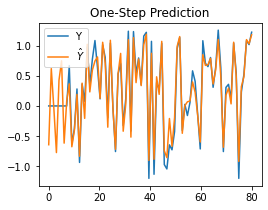

In [27]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('One-Step Prediction')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y),label='Y')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y_hat).detach(),label=r'$\hat{Y}$')
plt.legend();

#### Multi Step Prediction

In [28]:
prefixSize=20
totalSize=40
testShift=int(len(hmap)*(1-testSetRatio))

In [29]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[testShift:testShift+prefixSize],-1),torch.unsqueeze(preY[testShift:testShift+totalSize-1],-1)
#print('preX=',preX)
preY=[y for y in torch.cat((preX[:4],preY[2:-1]),dim=0)]
#print('preY=',preY)
len(preY)

40

In [30]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=totalSize-prefixSize)
#print('YHat=',YHat)
len(YHat)

40

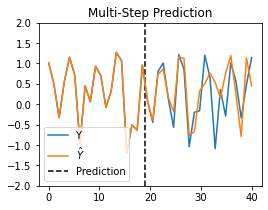

In [31]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('Multi-Step Prediction')
fig.set_ylim(-2,2)
plt.plot(torch.linspace(0,len(preY),len(preY)),preY,label='Y')
plt.plot(torch.linspace(0,len(preY),len(preY)),YHat,label=r'$\hat{Y}$')
plt.vlines([prefixSize-1],ymin=-2,ymax=2,linestyles='dashed',label='Prediction')
plt.legend();